# Compute ratemaps

(Based on code from Ganguli lab: https://github.com/ganguli-lab/grid-pattern-formation/blob/master/visualize.py)

In [1]:
import numpy as np
from matplotlib import pyplot as plt
import scipy
import scipy.stats
#from imageio mport imsave
import torch

from trajectory import TrajectoryParams, TrajectoryGenerator
from model import ModelHyperParams, PathRNN

In [2]:
def compute_ratemaps(model:PathRNN, tgen:TrajectoryGenerator, res=20, n_avg=None, Ng=100, idxs=None):
    '''Compute spatial firing fields'''

    # TODO: Replace
    # (copied this from main.py in Ganguli's code)
    BATCH_SIZE = 500
    BOX_WIDTH = 2.2
    BOX_HEIGHT = 2.2

    # TODO: Clean this up
    seq_length = tgen.params.n_steps


    if not n_avg:
        n_avg = 1000 // seq_length

    if not np.any(idxs):
        idxs = np.arange(Ng)
    idxs = idxs[:Ng]

    g = np.zeros([n_avg, BATCH_SIZE * seq_length, Ng])
    pos = np.zeros([n_avg, BATCH_SIZE * seq_length, 2])

    activations = np.zeros([Ng, res, res]) 
    counts  = np.zeros([res, res])

    for index in range(n_avg):

        # Sample test batch
        inputs, pos_batch = tgen.smp_batch(BATCH_SIZE)
        
        inputs = torch.Tensor(inputs)

        # TODO: Fix error here!
        # Run model on test batch
        #g_batch = model.g(inputs).detach().cpu().numpy()
        
        _, g_batch = model(inputs)
        g_batch = g_batch.detach().numpy()

        pos_batch = np.reshape(pos_batch, [-1, 2])
        g_batch = g_batch[:,:,idxs].reshape(-1, Ng)
        
        g[index] = g_batch
        pos[index] = pos_batch

        x_batch = (pos_batch[:,0] + BOX_WIDTH / 2) / BOX_WIDTH * res
        y_batch = (pos_batch[:,1] + BOX_HEIGHT / 2) / BOX_HEIGHT * res

        for i in range(BATCH_SIZE * seq_length):
            x = x_batch[i]
            y = y_batch[i]
            if x >=0 and x < res and y >=0 and y < res:
                counts[int(x), int(y)] += 1
                activations[:, int(x), int(y)] += g_batch[i, :]

    for x in range(res):
        for y in range(res):
            if counts[x, y] > 0:
                activations[:, x, y] /= counts[x, y]
                
    g = g.reshape([-1, Ng])
    pos = pos.reshape([-1, 2])

    # # scipy binned_statistic_2d is slightly slower
    # activations = scipy.stats.binned_statistic_2d(pos[:,0], pos[:,1], g.T, bins=res)[0]
    rate_map = activations.reshape(Ng, -1)

    return activations, rate_map, g, pos

In [3]:

def concat_images(images, image_width, spacer_size):
    """ Concat image horizontally with spacer """
    spacer = np.ones([image_width, spacer_size, 4], dtype=np.uint8) * 255
    images_with_spacers = []

    image_size = len(images)

    for i in range(image_size):
        images_with_spacers.append(images[i])
        if i != image_size - 1:
            # Add spacer
            images_with_spacers.append(spacer)
    ret = np.hstack(images_with_spacers)
    return ret


def concat_images_in_rows(images, row_size, image_width, spacer_size=4):
    """ Concat images in rows """
    column_size = len(images) // row_size
    spacer_h = np.ones([spacer_size, image_width*column_size + (column_size-1)*spacer_size, 4],
                       dtype=np.uint8) * 255

    row_images_with_spacers = []

    for row in range(row_size):
        row_images = images[column_size*row:column_size*row+column_size]
        row_concated_images = concat_images(row_images, image_width, spacer_size)
        row_images_with_spacers.append(row_concated_images)

        if row != row_size-1:
            row_images_with_spacers.append(spacer_h)

    ret = np.vstack(row_images_with_spacers)
    return ret


def convert_to_colormap(im, cmap):
    im = cmap(im)
    im = np.uint8(im * 255)
    return im


def rgb(im, cmap='jet', smooth=True):
    cmap = plt.cm.get_cmap(cmap)
    np.seterr(invalid='ignore')  # ignore divide by zero err
    im = (im - np.min(im)) / (np.max(im) - np.min(im))
    #if smooth:
    #    im = cv2.GaussianBlur(im, (3,3), sigmaX=1, sigmaY=0)
    im = cmap(im)
    im = np.uint8(im * 255)
    return im


def plot_ratemaps(activations, n_plots, cmap='jet', smooth=True, width=16):
    images = [rgb(im, cmap, smooth) for im in activations[:n_plots]]
    rm_fig = concat_images_in_rows(images, n_plots//width, activations.shape[-1])
    return rm_fig

In [4]:
# Directory where test data is loaded from
#TEST_DATA_DIR = 'data/sim_2022_04_19_cartesian'

# Path where model is saved
MODEL_FPATH = 'models/test_2022_04_20_02.pt'

traj_params = TrajectoryParams()
model_hparams = ModelHyperParams()


In [5]:
model = PathRNN(model_hparams)
model.load_state_dict(torch.load(MODEL_FPATH))
model.eval();

In [6]:
tgen = TrajectoryGenerator(traj_params)

In [7]:
activations, rate_map, g, pos = compute_ratemaps(model, tgen)

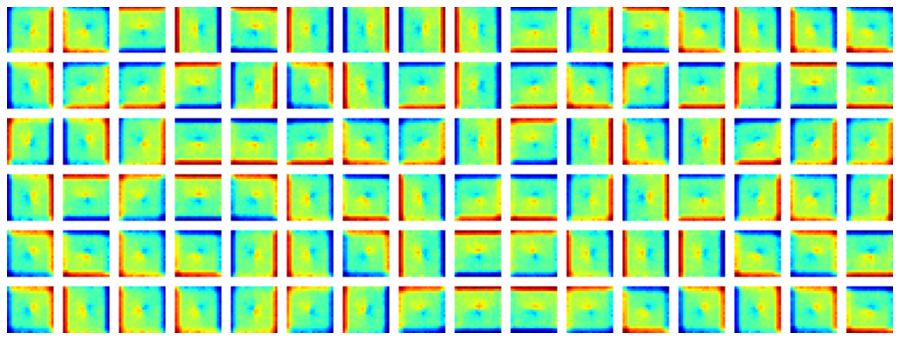

In [8]:
n_plot = 96
plt.figure(figsize=(16,4*n_plot//8**2))
rm_fig = plot_ratemaps(activations, n_plot)
plt.imshow(rm_fig)
plt.axis('off');